In [1]:
pip install adjustText

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from adjustText import adjust_text

<h2> Aims </h2>

The Our World in Data organisation amalgamates various covid statistics in a freely available [database](https://ourworldindata.org/coronavirus). I will use this data to answer three questions on the pandemic:

1. Which countries have suffered the worst Covid outbreaks?
2. Is there a correlation between population density and outbreak severity?
3. Is there good linear model which predicts deaths based upon case and/or ICU patient numbers?

<h2> Data Understanding </h2>
<h3> Our World in Data Covid Dataset </h3>

Contains covid data amalgamated by OWID from various sources. All countries have a unique identifying ISO_code, as does aggregated data for the whole world. Aggregated data for continents have no ISO code.

The data includes 58 columns. 3 are identifying -location/continent/iso_code, 40 are Covid specific datapoints, 15 are other  developmental/health data such as Human Development index and median age. 

The covid cases/deaths data points are largely clean, with NaN values only appearing during early periods for the most part. Presumably this is from when records did not exist (and thus no data could concievably be available), such NaN entries will therefore be replaced by 0. The exceptions here are Hong Kong, which does not have any covid datapoints, and a few countries which do not have any recorded covid deaths. It is unclear from the data if they simply have no deaths or if these records do not exist or where otherwise unavailable. In any case they can be ommited without impacting the answers to any of the questions posed.

Some of the other covid specific data, like number of tests conducted and number of ICU patients are missing for small and/or poor countries, but again none of these will impact our analsyses.

Similarly not all of the health and developmental data is available for every country. The only such data we will use however is population density, and only in Europe. Hence this will only impact the Vatican, which we would ignore anyway as it is not representative of a normal state.

<h3> JRC Population Weighted Density dataset </h3>

This dataset contains the population weighted density in 2010 for states in the European Union (in 2015), as well as predictions for later decades. We will only use the 2010 data. Full data on European states did not seem to be available else I would have used this. 

In [3]:
default_fields=['new_cases', 'new_deaths', 'icu_patients']

def pull(country='', continent='', start='2020-01-01', cols=default_fields):
    '''Pull data from Our World In Data covid csv
    
        Parameters:
            country (str): pull data for this country
            continent (str): pull data for all countries in this continent
            cols ([str]): headers of columns from which to pull date
            start (numpy.dtype or DatetimeTZDtype or str): pulls only data from after start date
        
        Returns:
            df (pandas.DataFrame): data for required columns/locations indexed by date
    
    '''
    
    
    file='owid-covid-data.csv'
    df=pd.read_csv(file)
    if not cols:
        cols=df.columns
    if 'date' not in cols:
        cols=['date']+cols
    if country:
        df=df[df.location == country].loc[:,cols]
    elif continent: 
        df=df[df.continent == continent].loc[:,cols]
    else:
        df=df.loc[:,cols]
    df.date=df.date.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
    df=df.set_index('date').loc[start:]
    return df

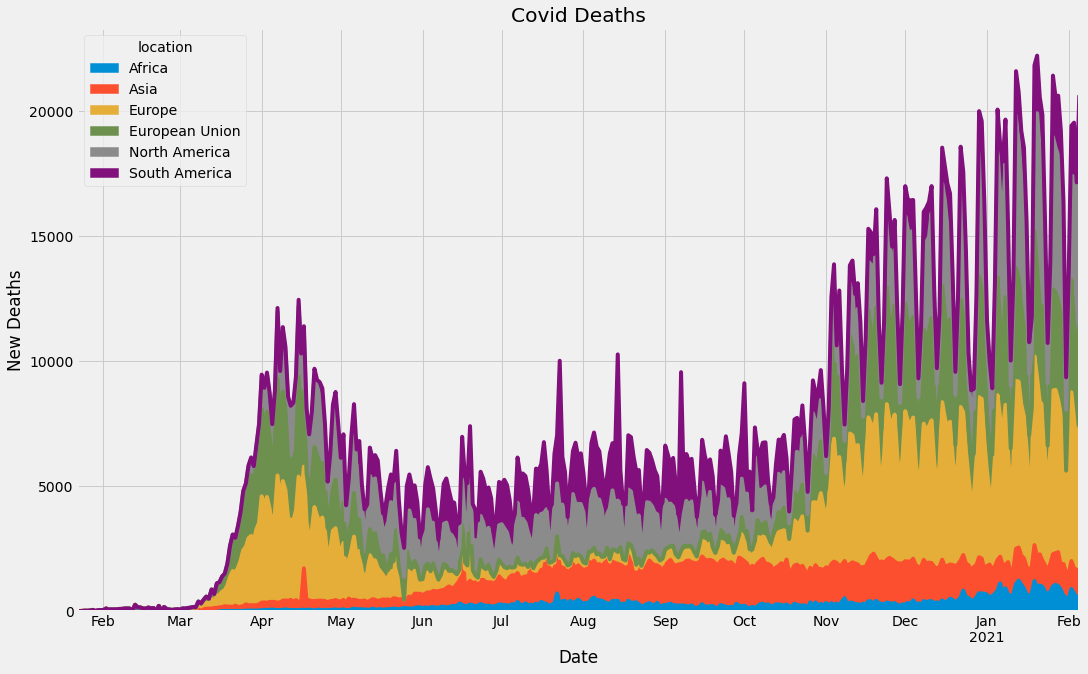

In [4]:
df=pull(cols=['location','iso_code','new_deaths', 'new_cases'])
df=df[df.iso_code.isna()].drop('iso_code', axis=1)
df=df[df.location !='International']
df=df.fillna(0)
df.loc[df.new_deaths < 0, 'new_deaths'] =0
df=df.reset_index()

plt.style.use('fivethirtyeight')

ndf=df.pivot_table(index='date',columns='location', values='new_deaths').fillna(0)
ndf['Asia']=ndf['Asia']+ndf['Oceania']
ndf=ndf.drop('Oceania', axis=1)

ndf.plot.area(figsize=(16,10),
             title='Covid Deaths',
             xlabel='Date',
             ylabel='New Deaths');

<h2>Q1: Which countries have suffered the worst Covid outbreaks?</h2>
In particular we'd like to find out which countries have the highest death/case counts proportionate to their population. 

In [5]:
df=pull(cols=['location','iso_code','total_deaths_per_million', 'total_cases_per_million']).loc['2021-02-1']
df=df.dropna(subset=['iso_code']).drop('iso_code', axis=1).set_index('location').drop('World').dropna()# drop continents/the world

In [6]:
deaths_rank=df[['total_deaths_per_million']].sort_values('total_deaths_per_million', ascending=False).take(range(10)).reset_index()
deaths_rank.index+=1
deaths_rank.columns= ['Country', 'Deaths per million']
deaths_rank


,Country,Deaths per million
1,San Marino,1974.188
2,Belgium,1822.666
3,Slovenia,1694.139
4,United Kingdom,1572.843
5,Czechia,1530.678
6,Italy,1469.440
7,Bosnia and Herzegovina,1439.886
8,North Macedonia,1375.649
9,Liechtenstein,1363.505
10,United States,1339.430


The ten worst outbreaks, as measured by deaths, consist almost entirely of European Countries. The exception being of course the United States coming in at number 10.

In [7]:
cases_rank=df[['total_cases_per_million']].sort_values('total_cases_per_million', ascending=False).take(range(10)).reset_index()
cases_rank.index+=1
cases_rank.columns= ['Country', 'Cases per million']
cases_rank

,Country,Cases per million
1,Andorra,129062.318
2,Montenegro,98671.787
3,Czechia,92196.345
4,San Marino,89133.125
5,Luxembourg,81046.238
6,Slovenia,80250.821
7,United States,79519.364
8,Israel,75355.891
9,Panama,74419.528
10,Portugal,71230.938


The countries with the most cases per million are a little less dominated by European Countries. Somewhat surprisingly only 4 countries appear on both lists. This could be a consequence of understated case counts in countries overwhelmed by the disease, or there might be an underlying epidemiological  cause such variations in population demographics making some countries more vulnerable.

<h2>Q2: Is there a correlation between population density and outbreak severity?</h2>
Once again we'll consider both total cases and total deaths as possible measures of outbreak severity. For this question we'll focus mainly on Europe, since this block is relatively similar and heavily affected. Plus there is good quality data on population density.

There are also two main measures of population density we might use. The first is the usual. $$Density=\frac{Population}{Area}$$

Alternatively we can use population weighted density. In principle for a country with population $X$ we have

$$\text{PWD}(d,X) = \frac{1}{|X|}\sum_{p \in X}N(p,d)$$
where $N(p,d)$ is the number of people living within $d$ of $p$. In practice this number is not computable, but we can break a country up into a set of pixels P_{i} of fixed area $a$, density $d_{i}$ and population $p_{i}$. Then 

$$\text{APWD}(a, X) =\frac{\sum_{P_{i}} d_{i}p_{i}}{\sum p_{i}} $$
gives an approximate measure, though it depends on our choice of pixels. We will take the population weighted density to be given by $AWD(1,X)$.

<h3> Data Preparation </h3>

In [8]:
df=pull(continent='Europe', cols=['location','iso_code','total_deaths_per_million', 'total_cases_per_million', 'population_density']).loc['2021-02-1']
df=df.dropna(subset=['iso_code']).drop('iso_code', axis=1).set_index('location').dropna()# drop continents/the world
df.rename(columns={'population_density':'Population Density'}, inplace=True)

In [9]:
file='pwd_country.csv'
pwd= pd.read_csv(file)
pwd=pwd[['COUNTRY_NAME', '2010']] ## Data for 2020 onwards are just estimates
pwd.columns=['Country Name', 'Population Weighted Density']
df=df.merge(pwd, left_index=True, right_on='Country Name', how='inner').set_index('Country Name')
df.rename(columns={'total_deaths_per_million':'Total Deaths Per Million', 'total_cases_per_million':'Total Cases Per Million'}, inplace=True)

<h3> Visualisation </h3>

Text(0.5, 1.0, 'Density vs Cases in Europe')

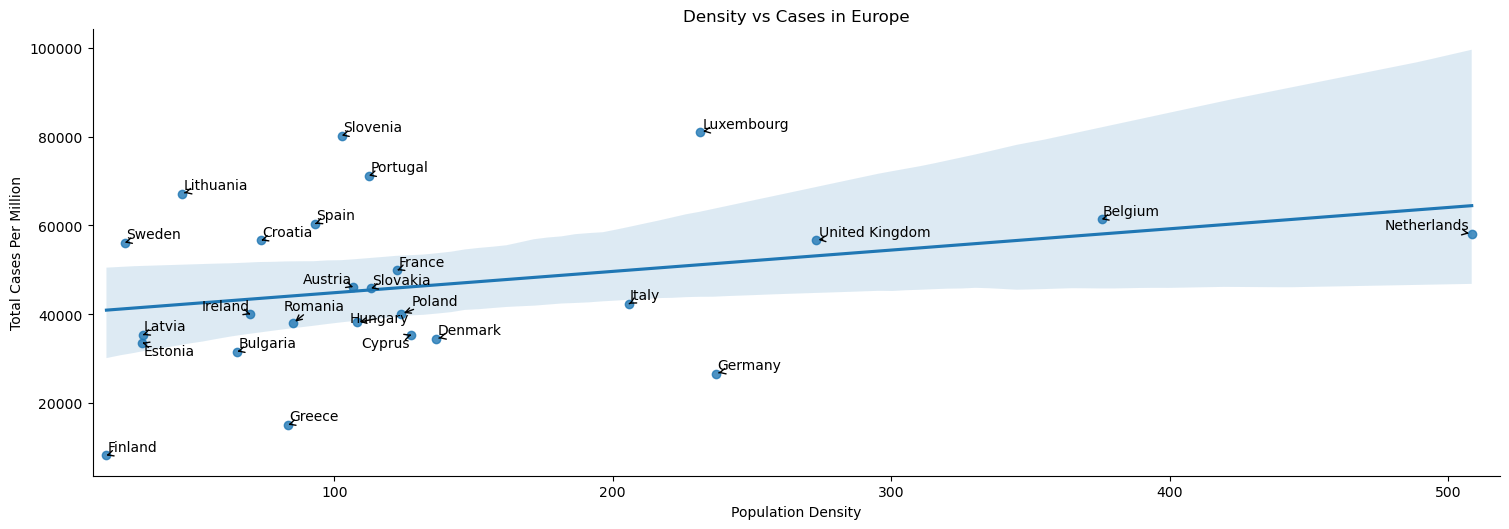

In [10]:
plt.style.use('default')

fig=sns.lmplot(data=df.drop(['Malta']), y='Total Cases Per Million', x='Population Density', fit_reg=True, aspect=3, height=5)
fig.set(xlim=(df.drop(['Malta'])['Population Density'].min()-5, df.drop(['Malta'])['Population Density'].max()+10))

labels=[]

for country in df.drop(['Malta']).index:
     labels.append(plt.text(df.loc[country,'Population Density']+0.01, df.loc[country, 'Total Cases Per Million'], 
     country))
labels
adjust_text(labels, arrowprops=dict(arrowstyle="->", color='black'));
plt.title('Density vs Cases in Europe')

If we plot total cases per million vs population density then there does seem to be something of a correlation. The line of best clearly doesn't give a good description of the relationship, so the Pearson Coefficient will be low. However we would expect a Spearman Rank calculation to find a modest correlation.

Text(0.5, 1.0, 'Population Weighted Density vs Cases in Europe')

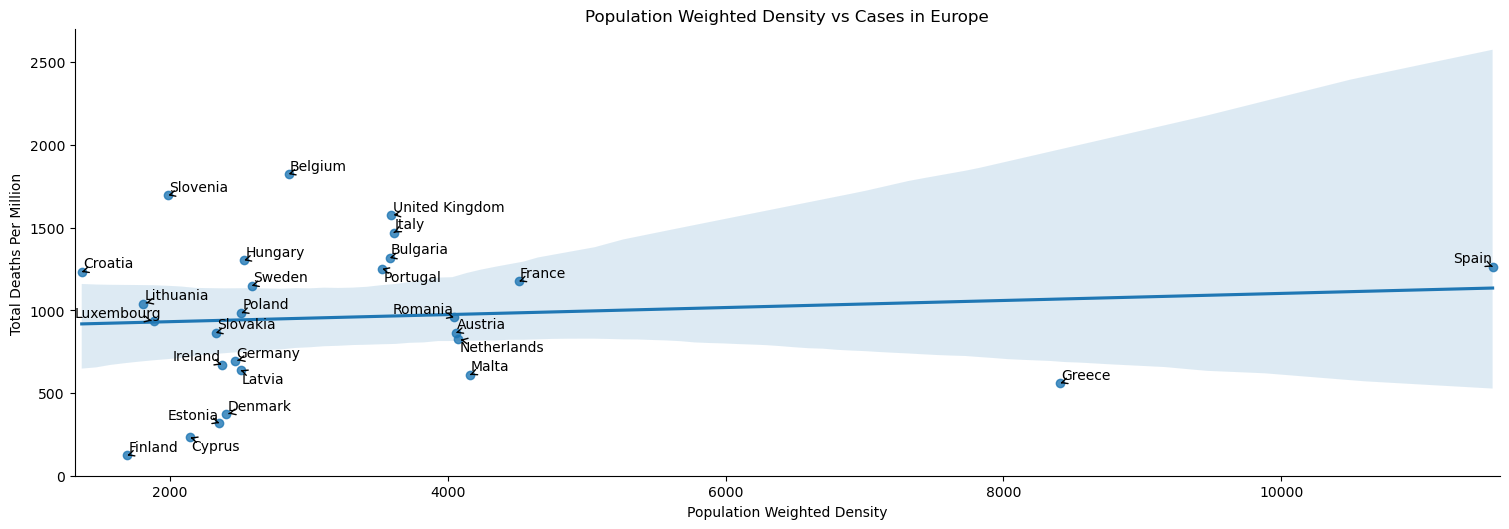

In [11]:
fig=sns.lmplot(data=df, y='Total Deaths Per Million', x='Population Weighted Density', fit_reg=True, aspect=3, height=5)
fig.set(xlim=(df['Population Weighted Density'].min()-50, df['Population Weighted Density'].max()+50))

labels=[]

for country in df.index:
     labels.append(plt.text(df.loc[country,'Population Weighted Density']+0.01, df.loc[country, 'Total Deaths Per Million'], 
     country))
labels
adjust_text(labels, arrowprops=dict(arrowstyle="->", color='black'));
plt.title('Population Weighted Density vs Cases in Europe')

<h3> Analysis </h3>

Very surprisingly, to me at least. There appears to be little relationship at all - the line of best fit is basically flat, and it is a poor desciptor besides. 

In [12]:
res=df.corr(method='pearson').drop(['Population Density', 'Population Weighted Density'], axis=1).merge(
    df.corr(method='spearman').drop(['Population Density', 'Population Weighted Density'], axis=1), left_index=True, right_index=True, suffixes=('-Pearson', '-Spearman')).loc[['Population Density', 'Population Weighted Density']]
res

,Total Deaths Per Million-Pearson,Total Cases Per Million-Pearson,Total Deaths Per Million-Spearman,Total Cases Per Million-Spearman
Population Density,-0.029020,0.063734,0.159951,0.288156
Population Weighted Density,0.103008,-0.058771,0.210623,0.003663


The correlation calculations backup the graphical observations. Neither measure of density has a strong linear correlation with deaths or cases. On the other hand the Spearman's rank calculations tell us there is some degree of correlation, with the strongest being between Total Cases and Population Density.

<h2>Q3: Is there good linear model which predicts deaths based upon case and/or ICU patient numbers?</h2>

Many commentators have given a variety of rules of thumb for estimate death rates 1/2 weeks in advance. Intuitively we would expect some essentially fixed proportion of ICU patients/ Covid cases not to survive, so some kind of linear model is a good candidate. Indeed all the estimates I have seen given are of this form.

There are of course complicating factors, most noticeably noise introduced to cases and deaths by periodic reporting cycles and that the new cases reported are not always a good estimate of the actual number of cases in the population. 

To answer this question we'll construct a few models on data from 2020 which we'll test on data from January 2021 to give us an idea of real world performance. Obviously it's not ideal that the test data isn't chosen at random, but it will do for our purposes.

<h3> Data Preparation and Visualisation </h3>

In [13]:
df=pull(country='United Kingdom')
df.index.rename('Date', inplace=True)
df.columns=['New Cases', 'New Deaths', 'ICU Patients']
df.isna().sum()

New Cases        0
New Deaths      35
ICU Patients    64
dtype: int64

Text(0.5, 1.0, 'Covid in the UK')

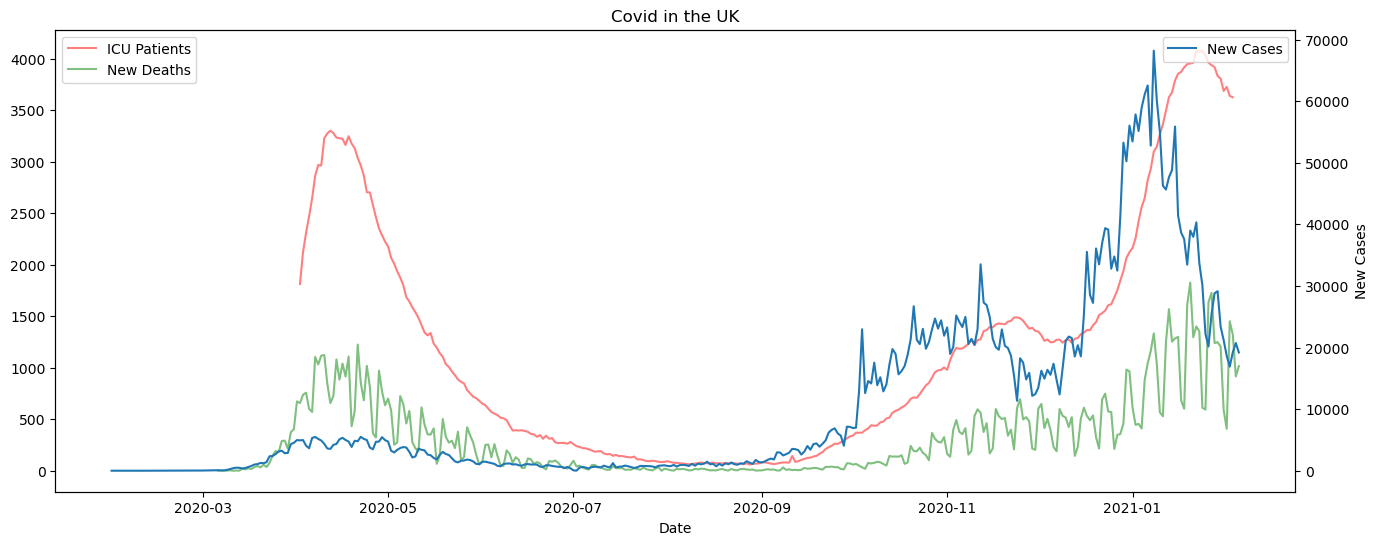

In [14]:
fig=plt.figure(figsize=(16, 6))
ax=sns.lineplot(data=df, x=df.index, y='ICU Patients', color='red', alpha=0.5)
sns.lineplot(data=df, x=df.index, y='New Deaths', ax=ax, color='green', alpha=0.5)
ax.set(ylabel='')
plt.legend(['ICU Patients', 'New Deaths']);
ax2=ax.twinx()
ax=sns.lineplot(data=df, x=df.index, y='New Cases', ax=ax2)
plt.legend(['New Cases']);
plt.title('Covid in the UK')

There is some missing data at the beginning of the pandemic. We can fill the NaN's with 0 but for the most part we'll avoid using data before mid-April, even when we have it the quality is very questionable. It can't be seen on the graph but the 2 most recent days of Icu patient numbers are missing too, these rows will have to be dropped.

Looking at the data, it does loosely seem, at least in the second half of the year, that the number of deaths follows ICU patients which in turn follows New Cases. As above however, there is a large amount of noise in both the death and case numbers.

In [15]:
df=df.fillna(0).iloc[:-2,:]

<h3> Analysis </h3>

In [16]:
def trail(df,cols,trail_from, trail_to=0, keepNan=False):
    #df must be date indexed
    #Trail_from and trail_to are either an integers or lists of length =col, can mix and match 
    #Includes data from between trail_from and trail_to days before
    #keepNan=True includes dates for which the trailing window has missing entries
    
    
    '''Adds trailing data to DataFrame as additional columns
    
        Parameters:
            df (pandas.DataFrame): input dataframe, must be date indexed
            cols ([str]): headers of columns to take trailing data from
            trail_from (int/[int]): furthest day back to include data from, integer or integer per column
            trail_to (int/[int]): closest day to include data from, integer or integer per column
            keepNan (bool): if True includes dates for which the trailing window has missing entries 
        
        Returns:
            ndf (pandas.DataFrame): dataframe which contains trailing data as additional columns
    
    '''
    
    
    if not isinstance(trail_from, list) and not isinstance(trail_to, list):  
        odf=pd.DataFrame(df[cols].copy())
        if not keepNan:
            ndf=df.iloc[trail_from:,:]
        else:
            ndf=df
        for i in range(0,trail_from+1,1):
            if i >= trail_to:
                ndf=ndf.merge(odf, how='left', left_index=True, right_index=True, suffixes=('','_-'+str(i)) )
            diff=dt.timedelta(days=1)
            odf.index=odf.index+diff
        
        ndf=ndf.drop(cols,axis=1)  
        ndf=ndf
        return ndf
    else:
        if not isinstance(trail_from, list):
            trail_from =len(cols)*[trail_from]
             
        if not isinstance(trail_to, list):
            trail_to =len(cols)*[trail_to]
        
        if len(cols)!=len(trail_from):
            raise ValueError('Trail_from must be the same length as cols')
        elif len(cols)!=len(trail_to):
            raise ValueError('Trail_to must be the same length as cols')
        else:
            if not keepNan:
                ndf=df.iloc[max(trail_from):,:]
            else:
                ndf=df
            
            for i in range(len(cols)):
                col=cols[i]
                n=trail_from[i]
                m=trail_to[i]
                #print(n,m,col)
                ndf=ndf.drop(col,axis=1).merge(trail(pd.DataFrame(df[col]), [col], n,m, keepNan=keepNan)
                                          ,how='left', left_index=True, right_index=True, suffixes=('x','y'))
            
        return ndf
def pipe(df, target='New Deaths', predictors=['New Cases', 'ICU Patients'],trailing=['New Cases', 'ICU Patients'], 
         trail_n=21,trail_to=7, smooth=7, cutoffs=(dt.date(2020,1,1), dt.date(2021, 1, 1))):
    #target (str)- variable to model
    #trailing (str/list of strs)- categories to include historial data for
    #trail_n (int/list of ints) # of days to include takes either single value or one value per category
    #trail_to (int/list of ints) # prevents inclusion of data more recent than trail_to days
    #smooth (int) - if non-zero replace target by n day trailing average
    #cutoffs (pair of datetimes)-restrict attention to dates between those given
    
    '''Pipeline for creating linear models
    
        Parameters:
            df (pandas.DataFrame): input dataframe, must be date indexed
            target (str): name of target variable
            predictors ([str]): names of predictor variables
            trailing [str]: columns to include trailing data of, susbet of predictors
            trail_n (int/ [int]): furthest day back to include data for, one value or one per trailing column
            trail_to (int/[int]): closest day to include data from, integer or integer per column
            smooth (int): if non-zero replace target by n day trailing average
            cutoffs (pair of datetimes): restrict attention to dates between those given
        
        Returns:
            trail_df (pandas.DataFrame): dataframe including trailing and smoothed data as relevant
            X (pandas.DataFrame): predictor columns of trail_df
            y (pandas Series): target column of trail_df
            y_pred (numpy array): predictions of linear model on X
            lm_model: scikit learn linear regression model trained to predict y from X
    
    '''
    
    
    df=df[[target]+predictors]        
        
    if smooth:
        target_series=trail(pd.DataFrame(df[target]), target,smooth).mean(axis=1).rename(target+'_smoothed'+str(smooth))
        #print(df.columns)
        df=df.drop(target, axis=1)
        target=target+'_smoothed'+str(smooth)
        #target_Series=target_series.rename(target)
    else:
        target_series=df[target]
        df=df.drop(target, axis=1)
        
    trail_df=trail(df, trailing ,trail_n, trail_to)
    
    if cutoffs:
        target_series=target_series.loc[cutoffs[0]:cutoffs[1]]
    
    if trail_df.shape[0] != target_series.shape[0]:
        merge_dat=trail_df.merge(target_series, how ='inner', left_index=True, right_index=True, suffixes=('',''))
        y=merge_dat.loc[:,target]
        X=merge_dat.drop(target, axis=1)
    else:
        y=target_series
        X=trail_df.drop(target)
    
    
    
    lm_model=LinearRegression()
    lm_model.fit(X,y)
    y_pred=lm_model.predict(X)
    
    return trail_df, X,y, y_pred, lm_model

def plotpred(x,y, y_pred):
    '''Plots actual and prediction y variable vs one x on the same axis
    
        Parameters:
            x (array like): x variable datapoints
            y (array like): actual y variable datapoints
            y_pred (arrray like): prediction y varaible datapoints
        
        Returns:
            None (but displays a plt plot)
    '''
    
    plt.figure(figsize=(16, 6))
    ax=sns.lineplot(x=x, y=y_pred)
    sns.lineplot(x=x, y=y, ax=ax, color='red', alpha=0.5)
    plt.legend(['Prediction','Actual'])
    
def coefdf(model, cols):
    '''Returns dataframe of coefficients for a linear model
    
        Parameters:
            model: scikit learn linear model
            cols [str]: names of predictor variables
        
        Returns:
            coefs (pd.DataFrame): dataframe with DataType, Days and Coefficient columns. 
    '''
    coefs=pd.DataFrame(model.coef_,cols).reset_index()
    coefs.columns=['Variable', 'Coefficient']
    
    def rowlabel(row):
        label=row[0].split('_')
        try: 
            c=int(label[-1])
            if len(label)==3:
                x=label[0]+'_'+label[1]
            else:
                x=label[0]
        except:
            c=0
            if len(label)==2:
                x=label[0]+'_'+label[1]
            else:
                x=label[0]
        return x,c, row[1]
    coefs=coefs.apply(rowlabel, axis=1, result_type='expand')
    coefs.columns=['DataType', 'Days', 'Coefficient']
    return coefs
    

MSE-TRAIN: 5940.809866056767


Text(0.5, 1.0, 'Model Estimate - Train')

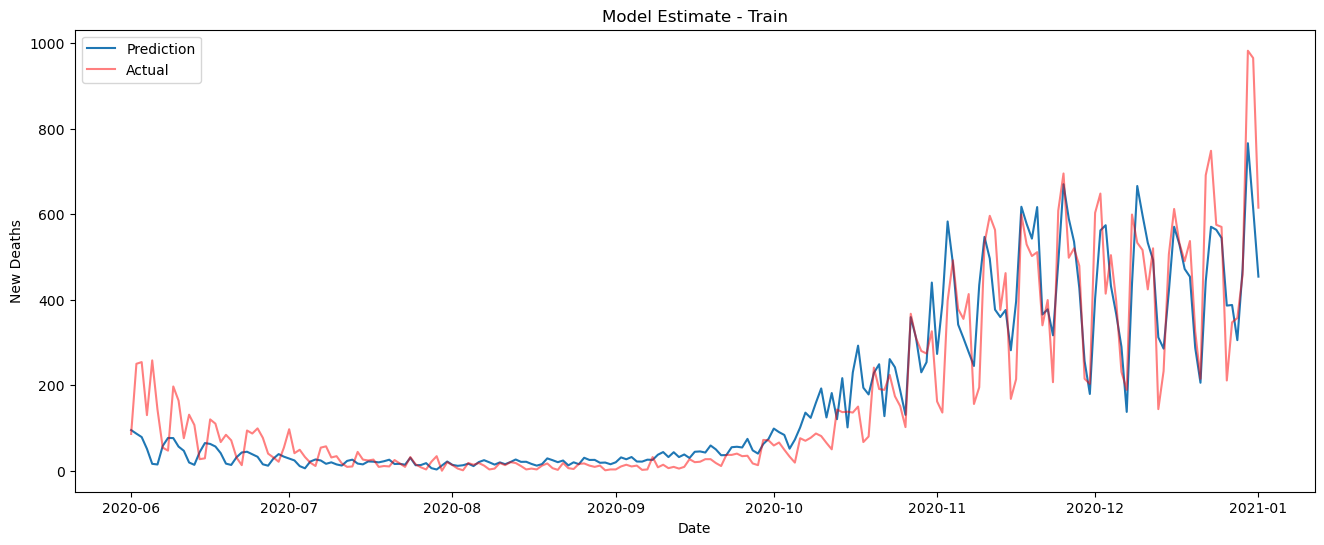

In [17]:
trail_df,X,y, y_pred, lm_model=pipe(df, predictors=['New Cases'], trailing=['New Cases'], trail_n=28, trail_to=6, smooth=0,cutoffs=(dt.date(2020,6,1)
, dt.date(2021, 1, 1)))
plotpred(y.index, y, y_pred)
print('MSE-TRAIN: '+str(mean_squared_error(y_pred,y)))
plt.title('Model Estimate - Train')

We can get a pretty good model by doing linear regression on case data from 1-4 weeks prior to the prediction date. The relatively large number of input variables mean we're in danger of overfitting, however, and unsuprsingly the model performs poorly on the test data as seen below.

MSE-TEST: 204928.58578130679


Text(0.5, 1.0, 'Model Estimate - Test')

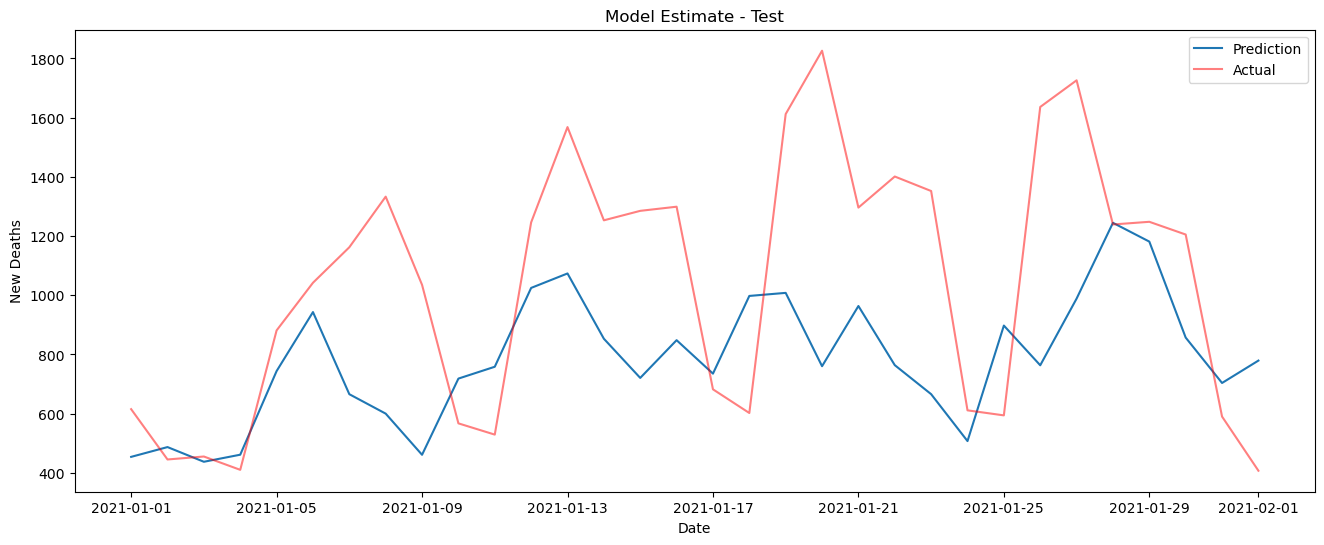

In [18]:
_,X,y, _, _=pipe(df, cutoffs=(dt.date(2021,1, 1)
, dt.date(2021, 2, 1)),predictors=['New Cases'], trailing=['New Cases'], trail_to=6,trail_n=28, smooth=0)
y_pred=lm_model.predict(X)
plotpred(y.index, y, y_pred)
print('MSE-TEST: '+str(mean_squared_error(y_pred,y)))
plt.title('Model Estimate - Test')

We could of course try including fewer days of data to combat this, but the performance remains poor. Regardless of the number of days included all the models systematically underestimate the number of deaths in the last few months of the year, it is possible this is caused by a fundamental shift in the relationship between case numbes and deaths, due to say the new variant or increasing pressure on the NHS reaching a tipping point.

The solution would seem to be to include data on ICU patients as well. Since this data is not subject to the same reporting patterns as deaths and cases it is important to smooth out the target data. We will do this by replacing New Deaths with its 7 day trailing average.

MSE-TRAIN: 1031.6156609066115
MSE-TEST: 943.9231580432015


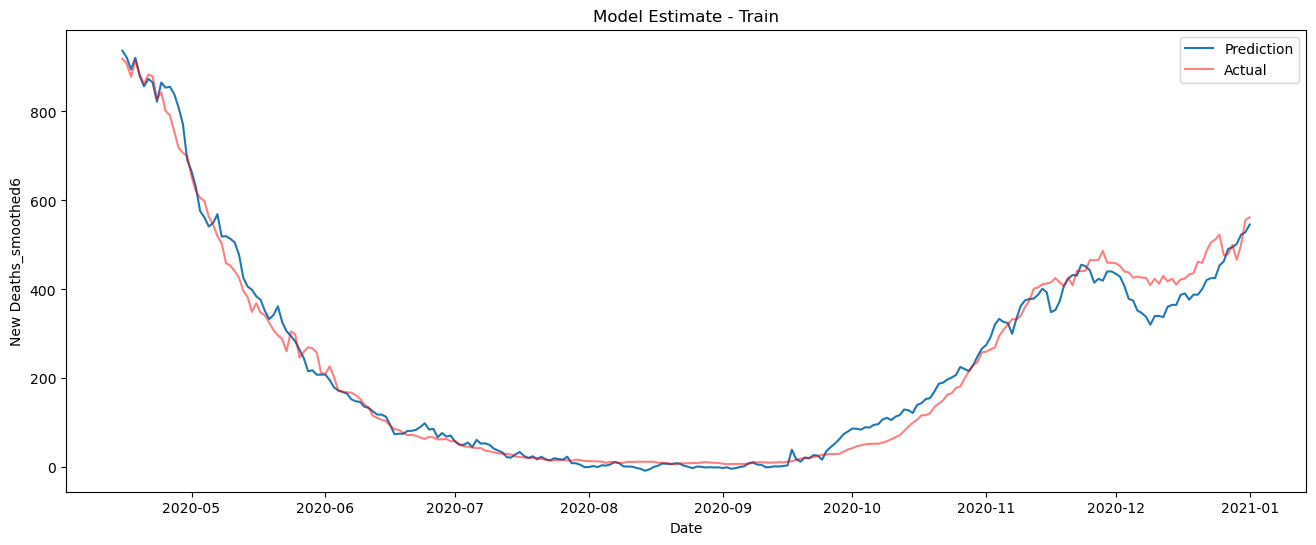

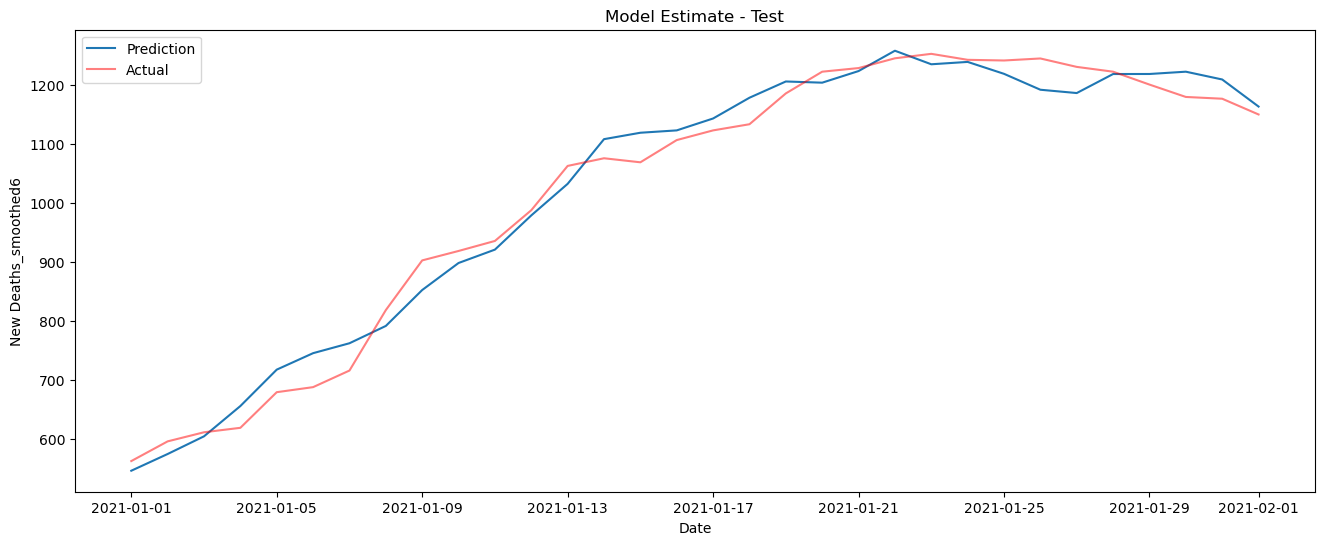

In [19]:
n=21
m=6
s=6

trail_df,X,y, y_pred, lm_model=pipe(df, predictors=['ICU Patients'], trailing=['ICU Patients'], trail_n=n, trail_to=m, smooth=s, cutoffs=(dt.date(2020,4,15)
, dt.date(2021, 1, 1)))
plotpred(y.index, y, y_pred)
plt.title('Model Estimate - Train')
print('MSE-TRAIN: '+str(mean_squared_error(y_pred,y)))
_,X,y, _, _=pipe(df, cutoffs=(dt.date(2021,1, 1)
, dt.date(2021, 2, 1)),predictors=['ICU Patients'], trailing=['ICU Patients'], trail_n=n,trail_to=m, smooth=s)
y_pred=lm_model.predict(X)
plotpred(y.index, y, y_pred)
plt.title('Model Estimate - Test')
print('MSE-TEST: '+str(mean_squared_error(y_pred,y)))

This model performs fantastically, though as before there is some underestimation on the training data in the last couple of months of 2020.

We see however that this model largely predicts from the most recent sets of ICU figures. This is the pattern no matter the date range - the best estimate of deaths on a given day is essentially given by whatever the most recent ICU data is. In particular, as the table below shows, the model performs quite poorly if we wish to predict more than about 10 days so in advance.

There is also a large negative contribution from ICU patients 2 weeks before the prediction date. I'm not sure what, if any, conclusions can be drawn from this.

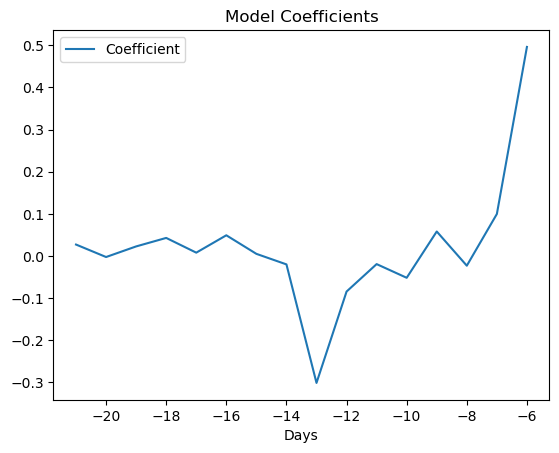

,MSE-Train,MSE-Test
Days in Advance,,
6,1014.029889,939.174420
7,1066.652549,1502.410034
8,1143.807228,2158.872645
9,1231.541817,3060.384042
10,1368.903144,4652.414112
11,1516.587424,7284.454743
12,1676.000038,11167.849954
13,1876.202486,15816.353031
14,2127.641697,21250.184051


In [21]:
coefdf(lm_model,X.columns).drop('DataType',axis=1).plot(x='Days', y='Coefficient')
plt.title('Model Coefficients')
plt.show()

def train_model(days):
    
    '''Train a linear model at a given prediction intervals for comparison
    
        Parameters:
            days: prediction interval
        
        Returns:
            unnamed pandas.Series: Meansquare Error values on test and train datasets
    '''
    
    trail_df,X,y, y_pred, lm_model=pipe(df, predictors=['ICU Patients'], trailing=['ICU Patients'], trail_n=days+15, trail_to=days, smooth=s, cutoffs=(dt.date(2020,4,10+days)
                                        , dt.date(2021, 1, 1)))
    tr=mean_squared_error(y_pred,y)

    _,X,y, _, _=pipe(df, cutoffs=(dt.date(2021,1, 1)
                    , dt.date(2021, 2, 1)),predictors=['ICU Patients'], trailing=['ICU Patients'], trail_n=days+15, trail_to=days, smooth=s)
    y_pred=lm_model.predict(X)
    te=mean_squared_error(y_pred,y)
    
    return pd.Series([tr,te])

res=pd.Series(range(6,15))
res.index=range(6,15)
res=res.apply(train_model)
res.columns=['MSE-Train', 'MSE-Test']
res.index.rename('Days in Advance', inplace=True)
res

We can construct a model that uses both these features to give pretty good performance. By using both case numbers and ICU patient numbers we can predict smoothed deaths reasonably well using only data from 2-3 weeks prior to the prediction date. It is possible that the falling real death count at the end of January, relative to the predicted rate, is a consequence of the vaccines being distributed but it's too early to tell at this stage.

MSE-TRAIN: 1147.9713600595273
MSE-TEST: 8709.496501571946


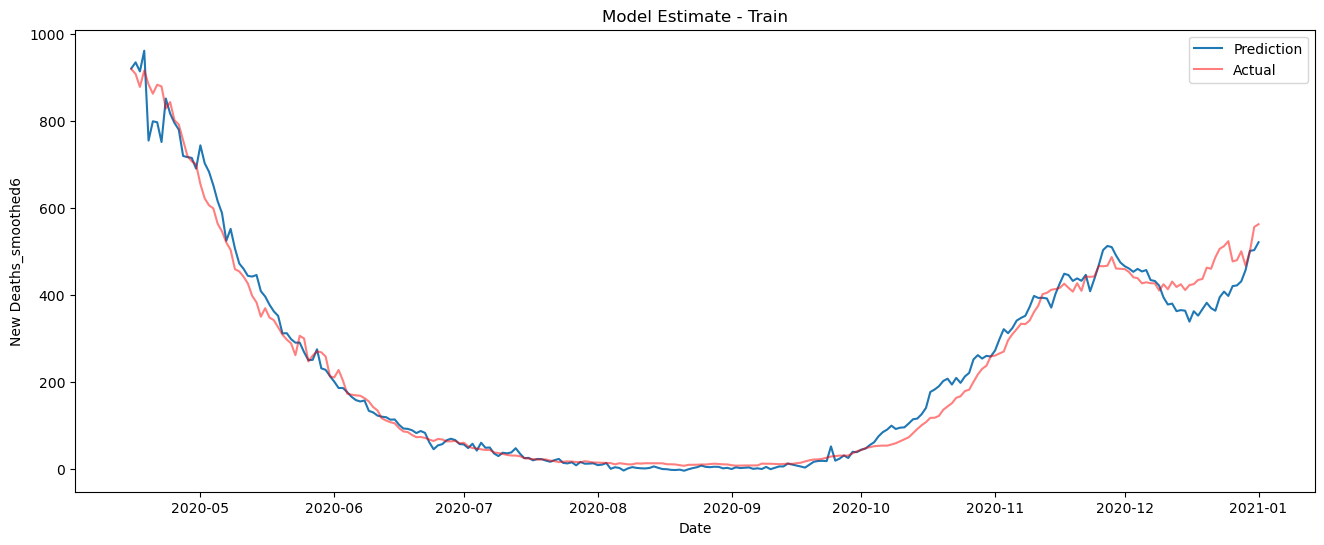

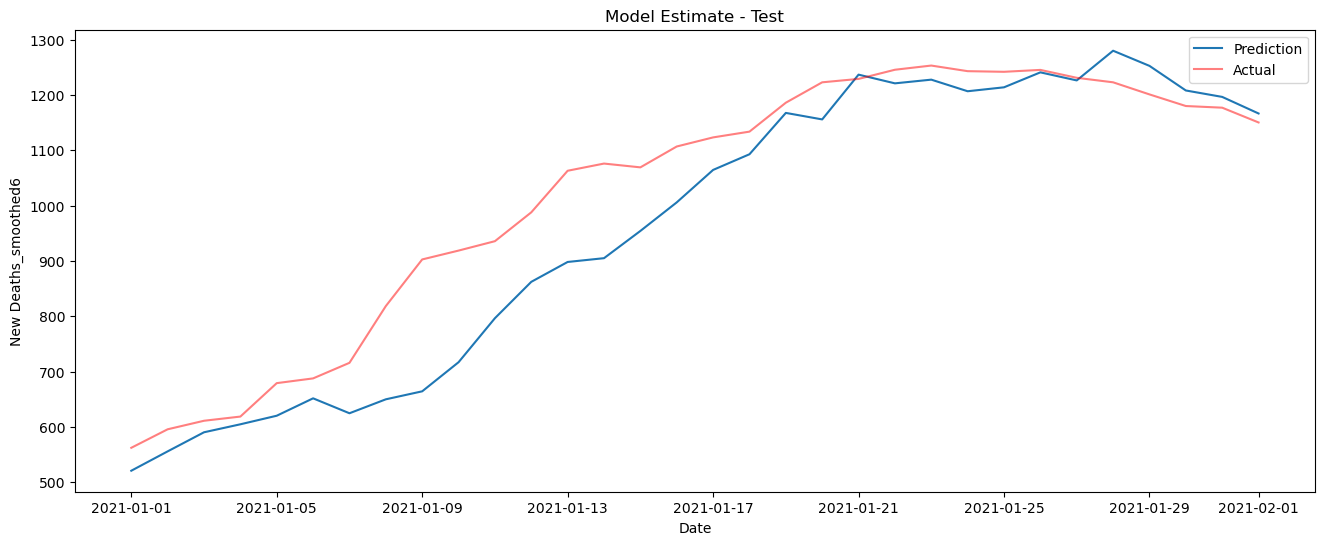

In [22]:
s=6
m=[13,13]
n=[17, 17]

trail_df,X,y, y_pred, lm_model=pipe(df, cutoffs=(dt.date(2020,4,15)
, dt.date(2021, 1, 1)), trail_to=m,trail_n=n, smooth=s)
print('MSE-TRAIN: '+str(mean_squared_error(y_pred,y)))
plotpred(y.index, y, y_pred)
plt.title('Model Estimate - Train')
_,X,y, _, _=pipe(df, cutoffs=(dt.date(2021,1, 1)
, dt.date(2021, 2, 1)), trail_to=m,trail_n=n, smooth=s)
y_pred=lm_model.predict(X)
plotpred(y.index, y, y_pred)
plt.title('Model Estimate - Test')
print('MSE-TEST: '+str(mean_squared_error(y_pred,y)))

In [23]:
coefdf(lm_model,X.columns)

,DataType,Days,Coefficient
0,New Cases,-13,0.003011
1,New Cases,-14,0.001792
2,New Cases,-15,0.001377
3,New Cases,-16,0.000667
4,New Cases,-17,0.000634
5,ICU Patients,-13,0.500276
6,ICU Patients,-14,-0.077884
7,ICU Patients,-15,-0.049200
8,ICU Patients,-16,-0.000049
9,ICU Patients,-17,-0.151851


If you're looking for something simpler in your life and want to predict the deaths a couple of weeks in advance, the following model does a suprisingly good job just using cases and ICU patients 2 weeks prior. Curiously this model outperforms the larger one on the test data, this is conceivably a consequence of overfitting in the earlier model but is most likely chance.

MSE-TRAIN: 2205.3730265846057
MSE-TEST: 6771.252361986921


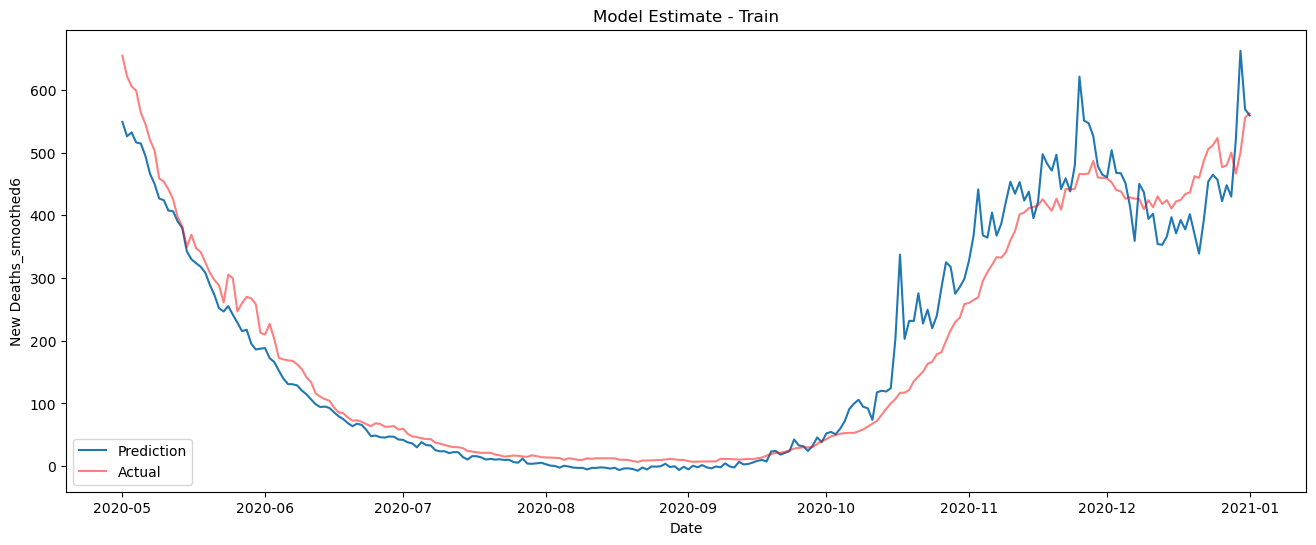

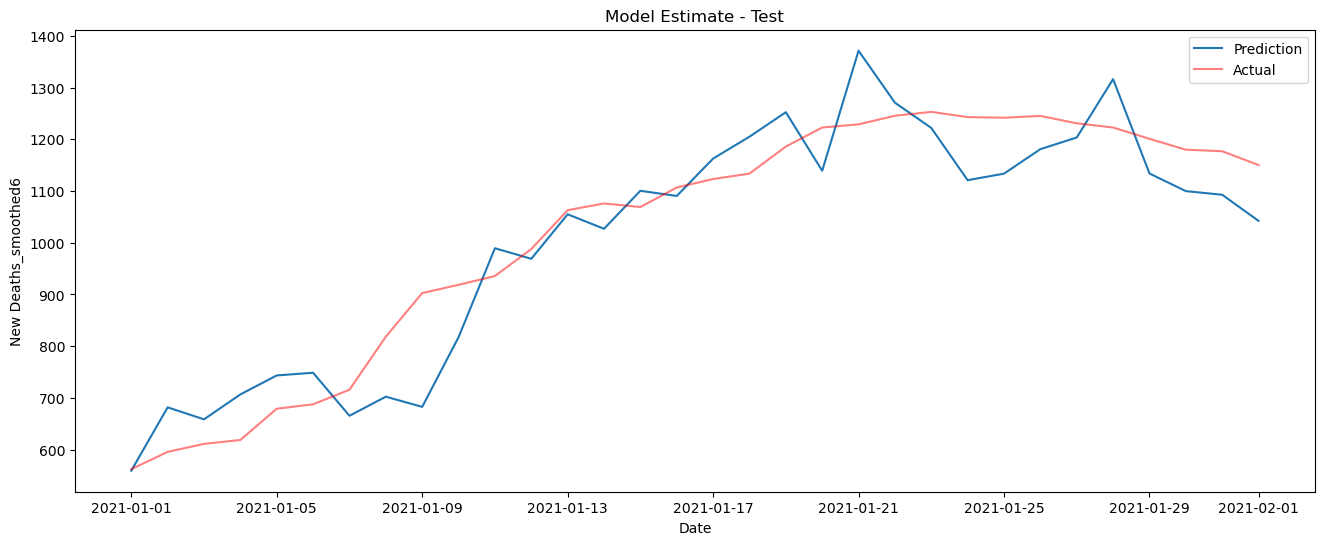

In [24]:
m=[13,13]
n=[13,13]
s=6

trail_df,X,y, y_pred, lm_model=pipe(df, cutoffs=(dt.date(2020,5,1)
, dt.date(2021, 1, 1)), trail_to=m,trail_n=n, smooth=0) ## Not modelled against smoothed data because not enough information provided 
_,X,y, _, _=pipe(df, cutoffs=(dt.date(2020,5, 1)
, dt.date(2021, 1, 1)), trail_to=m,trail_n=n, smooth=s)
print('MSE-TRAIN: '+str(mean_squared_error(y_pred,y)))
plotpred(y.index, y, y_pred)
plt.title('Model Estimate - Train')
_,X,y, _, _=pipe(df, cutoffs=(dt.date(2021,1, 1)
, dt.date(2021, 2, 1)), trail_to=m,trail_n=n, smooth=s)
y_pred=lm_model.predict(X)
plotpred(y.index, y, y_pred)
plt.title('Model Estimate - Test')
print('MSE-TEST: '+str(mean_squared_error(y_pred,y)))

In [25]:
coefdf(lm_model,X.columns)

,DataType,Days,Coefficient
0,New Cases,-13,0.013331
1,ICU Patients,-13,0.157938


Overall, neither ICU patients nor cases are particularly good predictors of reported deaths at 2 weeks; though, after smoothing the data, the number of ICU patients can be used to predict deaths in the next week extremely well. Combined they offer a pretty good estimation at 2 weeks, even if you restrict to just a single days worth of data.

We could likely estimate deaths even better if we included a contribution of some kind from the positivity rate to estimate how many cases go unnoticed, it's not clear however exactly how this would be best implemented, especially if we wished to ensure that relationship would be well approximated by some linear function. You're welcome to give it a try yourself though, if you have a couple of hours free.

There's also this period at the end of 2020 where almost all the models underestimate the number of deaths. Why do you think this is?

<h2> Evaluation </h2>

Overall we have identified the worst hit countries, investigated the relationship between population density and explored the use of linear regression in predicting covid deaths. The results of the first inquiry are largely self explanatory, with the main additional conclusion being that Europe is heavily overrepresented among the such countries. Discussions about why will likely be long, difficult and contentious as we plan to deal with future pandemics.

We rather unexpectedly found that weighted population density has little correlation with covid cases or deaths in European countries, though we did find a small correlation between them and population density. 

In the final section several models were presented. The case number only model was clearly inferior, though the other models had their own advantages and disadvantages - namely relative simplicity and accuracy at different prediction intervals. I think it is fair to say, however, that it was successfully demonstrated that linear models can be useful and accurate here so long as ICU patient data is used, as opposed to case data alone.  There was also a strange and unexplained underestimation of covid deaths towards the end of 2020. This might be an interesting area for further study.